## Load packages

In [2]:
using Revise
using SourceSeparationINN
using LinearAlgebra, Random, Distributions
using HDF5, JLD2
using PyPlot
using ProgressMeter

BLAS.set_num_threads(1)
Random.seed!(1234);

## Load data

In [3]:
# load data
data_signal_train = Data("../../../../data/train/processed/" .* readdir("../../../../data/train/processed"), Float64)
data_signal_test = Data("../../../../data/test/processed/" .* readdir("../../../../data/test/processed"), Float64);

## Model specification

In [4]:
function create_nar_model(dim; shift=1, batch_size::Int=128)

    return Model(
        dim,
        (
            ARLayer(
                dim,
                Model(  
                    dim-shift,
                    shift,
                    (   
                        DenseLayer(dim-shift, 16; batch_size=batch_size),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseLayer(16, 16; batch_size=batch_size),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseLayer(16, shift; batch_size=batch_size)
                    );
                    batch_size=batch_size
                );
                batch_size=batch_size
            ),
        );
        batch_size=batch_size
    )
        
end
batch_size = 128
dim_in = 16
loss_function_signal = MSE(batch_size=batch_size)
;

## Training

In [5]:
# load/train signal model
if isdir("logs/signal")

    # load model
    model_signal = load(string("logs/signal/", readdir("logs/signal")[1], "/model.jld2"))["model"]

else

    # create model
    model_signal = create_nar_model(dim_in; batch_size=batch_size)

    # set learning rate
    # setlr!(model_signal, 1e-5)

    # create train suite
    train_suite_signal = TrainSuite(
        model_signal,           # model
        loss_function_signal,   # loss function
        data_signal_train,      # train data
        data_signal_test,       # test data
        10,                     # number of epochs
        "logs/signal/"          # path to log directory
    );

    # create folder
    mkdir("logs/signal")

    # train model
    run!(train_suite_signal)

end;

epoch 010: 100%|████████████████████████████████████████| Time: 0:09:08
  mse_train:  0.0017111345205027809
  mse_test:   0.00220056752029237


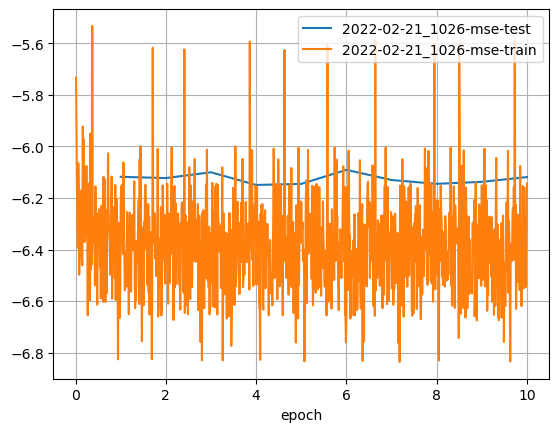

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\s151781\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


In [6]:
plot_logs(; path="logs/signal/", logscale=true);

## Denoising

In [7]:
function EKF(signal_mix, model, m_x_prior, V_x_prior, H, R, Q; dim_in=16)

    # allocate output
    m_x_f = Vector{Vector{Float64}}(undef,length(signal_mix))
    V_x_f = Vector{Matrix{Float64}}(undef,length(signal_mix))

    # copy priors
    m_x = copy(m_x_prior)
    V_x = copy(V_x_prior)

    # kalman filtering
    for k in dim_in+1:length(signal_mix)
    
        # predict step
        m_x_new = forward(model, m_x)
        F = jacobian(model, m_x)
        V_x_new = F*V_x*F' + Q
    
        # filtering messages
        y = signal_mix[k] - dot(H, m_x_new)
        S = dot(H, V_x_new, H) + R
        K = V_x_new * H * inv(S)
        m_x = m_x_new + K*y
        # V_x = V_x_new - K*S*K'
        V_x = (I - K*H')*V_x_new
    
        # save values
        m_x_f[k] = copy(m_x)
        V_x_f[k] = copy(V_x)
    
    end

    m_signal_filtering = [m_x_f[k][1]                       for k = dim_in+1:length(signal_mix)]
    V_signal_filtering = [V_x_f[k][1,1]                     for k = dim_in+1:length(signal_mix)]

    # return output
    m_signal_filtering, V_signal_filtering
    
end

EKF (generic function with 1 method)

In [10]:
SNR_in = map(x -> 10^(x/10), -10:1:10)
SNR_out = Vector{Vector{Float64}}(undef, length(SNR_in))
@showprogress for k = 1:length(SNR_in)

    SNR = Vector{Float64}(undef, length(data_signal_test))

    for ki in 1:length(data_signal_test)

        H = zeros(dim_in)
        H[1] = 1

        Q = zeros(dim_in, dim_in)
        Q[1,1] = exp(-6.1) * dim_in

        m_x_prior = randn(dim_in)
        V_x_prior = 1e2*diagm(ones(dim_in))

        noise_var = mean(abs2.(data_signal_test[ki])) / SNR_in[k]

        m_x, v_x = EKF(data_signal_test[ki] .+ sqrt(noise_var) .* randn(length(data_signal_test[ki])), model_signal, m_x_prior, V_x_prior, H, noise_var, Q)
        SNR[ki] = mean(abs2.(data_signal_test[ki][1+dim_in:end])) / mean(abs2.(data_signal_test[ki][1+dim_in:end] .- m_x))
    end

    SNR_out[k] = copy(SNR)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:15:28


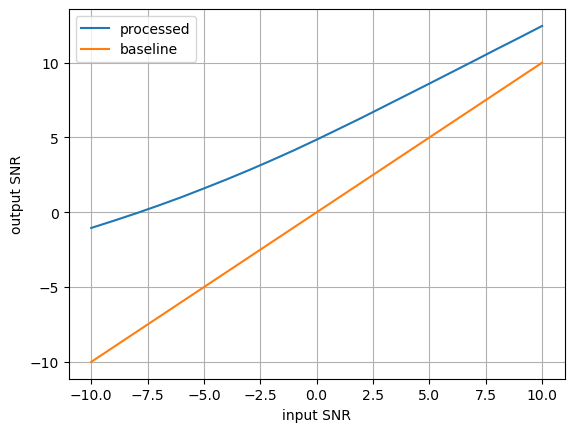

In [11]:
plt.plot(10 .*log10.(SNR_in), 10 .* log10.(mean.(SNR_out)), label="processed")
plt.plot(10 .* log10.(SNR_in), 10 .* log10.(SNR_in), label="baseline")
plt.grid()
plt.legend()
plt.xlabel("input SNR")
plt.ylabel("output SNR")
plt.savefig("NAR_SNR.png")